# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPRjJ' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24vBgwXKyPi5b' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEYDS9VfIzOboQo'<br />

## Modulo para autenticação no twitter

In [1]:
#!pip install twitter
#!pip install pymongo

In [2]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPRjJ'
    CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b'
    OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24vBgwXKyPi5b'
    OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEYDS9VfIzOboQo'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [3]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [4]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [5]:
q = 'brasil'
q = 'Anitta'
result = twitter_search(twitter_api, q, max_results=1000)
type(result)

list

In [6]:
result[0]

{'created_at': 'Tue Nov 05 12:08:20 +0000 2019',
 'id': 1191688698083135488,
 'id_str': '1191688698083135488',
 'text': 'RT @thiago_p: A @Anitta zerou o Halloween vestida de Elvira https://t.co/7blhx1HoAJ',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'thiago_p',
    'name': 'Thiago Pasqualotto',
    'id': 16033602,
    'id_str': '16033602',
    'indices': [3, 12]},
   {'screen_name': 'Anitta',
    'name': 'Anitta',
    'id': 141817380,
    'id_str': '141817380',
    'indices': [16, 23]}],
  'urls': [],
  'media': [{'id': 1189724896542281734,
    'id_str': '1189724896542281734',
    'indices': [60, 83],
    'media_url': 'http://pbs.twimg.com/media/EILAfW7XUAYBSNN.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/EILAfW7XUAYBSNN.jpg',
    'url': 'https://t.co/7blhx1HoAJ',
    'display_url': 'pic.twitter.com/7blhx1HoAJ',
    'expanded_url': 'https://twitter.com/thiago_p/status/1189724903186030593/photo/1',
    'type': 'ph

In [7]:
len(result)

1090

In [8]:
q = 'petrobras'
q = 'sarampo'
q = '#IveteSangaloNoTVZ'
q = '#AbortoÉCrime'
q = 'neymar'
q = 'Anitta'

twitter_api = oauth_login()
results = []
for i in range(1):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
    #results += result
#print(type(result))
#print(type(results))
print("Numero de tweets capturados: ", len(results))

#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

capturando  1091  tweets...
Numero de tweets capturados:  1091


In [9]:
results[2] 

{'created_at': 'Tue Nov 05 12:08:12 +0000 2019',
 'id': 1191688664335683590,
 'id_str': '1191688664335683590',
 'text': 'Ele é pai mt responsável por sinal, pra aceitar gravar qualquer porcaria....\nMitou se recusando a ir em programa na… https://t.co/0jK68vLl7U',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/0jK68vLl7U',
    'expanded_url': 'https://twitter.com/i/web/status/1191688664335683590',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 297156678,
  'id_str': '297156678',
  'name': 'Paula Magela Rocha',
  'screen_name': 'Paula_Magela',
  'locati

In [10]:
results[1]['created_at']

'Tue Nov 05 12:08:20 +0000 2019'

In [11]:
results[1]['metadata']['iso_language_code']

'es'

In [12]:
len(results)

1091

## imprimindo tweets

In [13]:
#result = results
i = 0
for tweet in results:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

@SolteiroPolis @Anitta @Ludmilla @pabllovittar é exatamente pra eles esse recado
RT @thiago_p: A @Anitta zerou o Halloween vestida de Elvira https://t.co/7blhx1HoAJ
Ele é pai mt responsável por sinal, pra aceitar gravar qualquer porcaria....
Mitou se recusando a ir em programa na… https://t.co/0jK68vLl7U
Os fãs da Anitta acham que ela criou a divulgação na gringa com Sim ou Não, kkk.

João Gilberto e Roberto Carlos te… https://t.co/btHK8jeSVm
@anitta https://t.co/ORvlpa6c37
RT @AcessoAnittaR: "Levante-se e brilhe" — Anitta via Instagram. https://t.co/aHiligMbG5
RT @anittaisfuego: Anitta repostou esse vídeo no ig só posso dizer que escolhi a artista certa pra amar,exemplo de determinação por que nad…
@bixa_e @AnittaRexha @Anitta @Ludmilla @pabllovittar Acha a pq to falando de fankeiras sou viado k kk kkk 
Acorda,… https://t.co/0DCIshFHbt
@sempacienciaoh @AnittaDailyC @Anitta @MariliaMReal Kkk to nelvosaaaaa
saudades da anitta com a lorena eu me acabava de rir
📊 | "Some Que ele Vem atrás

## Nuvem de Palavras - tweet

### Stopwords

In [14]:
# instalando o módulo de stopwords
#!pip install stop-words
results = result

In [15]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')
#stop_words
stop_words_portugues = get_stop_words('pt')
#stop_words_portugues
stop_words = stop_words_english + stop_words_portugues
print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [16]:
#!pip install wordcloud

In [17]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text']
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

94388


<Figure size 2000x1000 with 1 Axes>

<Figure size 2000x1000 with 1 Axes>

## Estatistica de contagem de palavras

In [18]:
words = stext.split()

In [19]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

anitta
la
vem
acessoanittar:
msica
parceria
anitta:
cantora
roslia
stories
lourdiz
nova
pra
atrs
j
mostram
vocais
cano
:
novos
sonhada
del
mundo
pabllo
mariliamreal
bem
favela
conquista
melhor
clarincom:
anittadailyc:
fez
dormir
s
"
finalmente
vou
duart
vnoliveiraa_:
paranias:


In [20]:
for i in range(15):
    print (c.popitem())

('hitzteria', 1)
('made', 1)
('louis_tomlinson', 1)
('semesta', 1)
('ragu', 1)
('isyanasarasvati', 1)
('anittalistenup', 1)
('tco/qmwmqbpicjrt', 1)
('di', 1)
('makara', 1)
('olacakm;', 1)
('suresi', 1)
('bakara', 2)
('antta', 1)
('yaplyormu', 1)


## colocando as palavras e suas frequencias do twitter num dataframe

In [21]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

,Word,Frequency
0,anitta,803
1,la,122
2,vem,106
3,acessoanittar:,92
4,msica,89
5,parceria,84
6,anitta:,83
7,cantora,81
8,roslia,74
9,stories,72


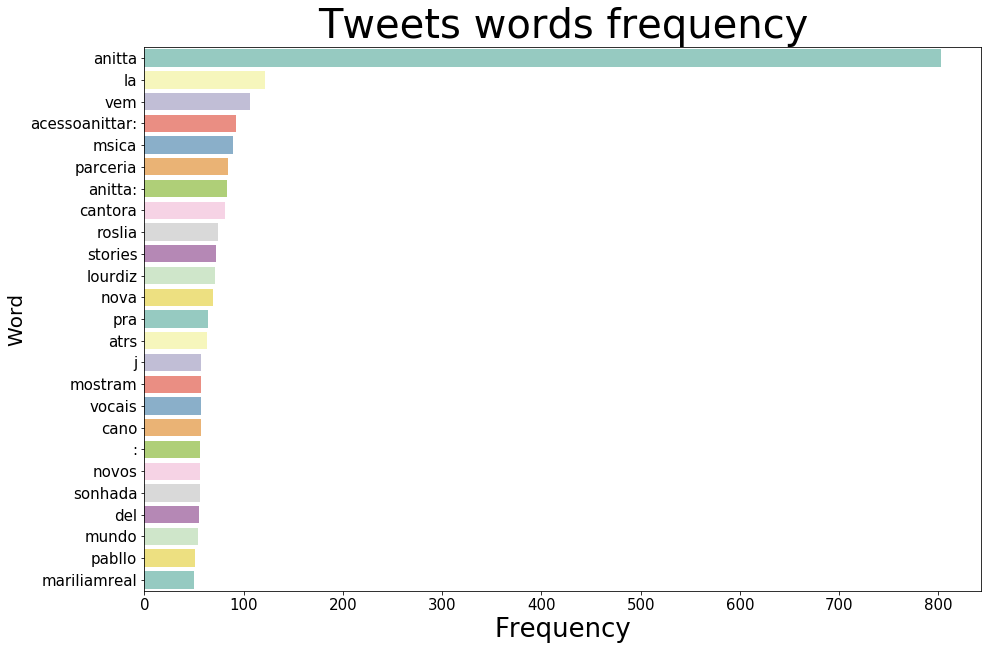

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [23]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

2
{'Brazil', 'Ireland'}


In [24]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

347

In [25]:
for i in range(15):
    print(location.pop())


Illuminate
Marco de Canaveses, Portugal
Vila Velha,Es
Angra dos Reis, Brasil   
São Caetano do Sul, Brasil
Acari, Rio de Janeiro
Somewhere. LOST 
Braga
WORLDWIDE
Setor Norte - Maracanã 
Duque de Caxias, Brasil
Brazil - Rio De Janeiro
Tocantinópolis, Brasil
Casa Nova, Brasil


## contar a ocorrencia de cada cidade

In [26]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [27]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

,city,frequency
0,"São Miguel, São Paulo",1
1,"Goiânia, Brasil",1
2,Amsterdam,1
3,"Pé de Serra, Brasil",1
4,they/she • xxi • ♊,1
5,"Distrito Federal, Brasil",1
6,"Porto, Portugal",1
7,"Porto Alegre, RS.",1
8,"Portimão, Portugal",1
9,"Niterói, Rio de Janeiro",1


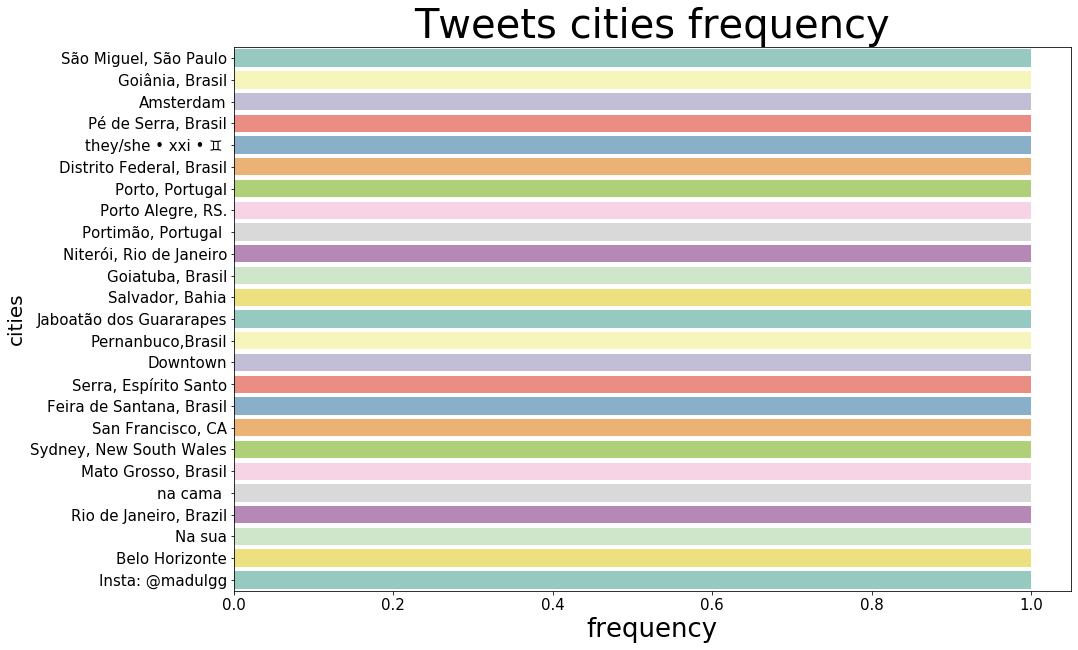

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [29]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [30]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

14


In [31]:
len(tweets_com_coordenadas)/len(results) * 100

1.2832263978001834

In [32]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'type': 'Polygon',
 'coordinates': [[[-45.089302, -22.153392],
   [-44.981501, -22.153392],
   [-44.981501, -22.076212],
   [-45.089302, -22.076212]]]}

In [33]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[-45.089302, -22.153392],
  [-44.981501, -22.153392],
  [-44.981501, -22.076212],
  [-45.089302, -22.076212]]]

In [34]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[-45.089302, -22.153392]

In [35]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [36]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[-45.089302, -22.153392],
 [-46.826039, -24.008814],
 [-38.466552, -12.8738743],
 [-34.9738347, -7.243257],
 [-44.062789, -20.059816]]

In [37]:
len(tweets_com_coordenadas)

14

In [38]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [39]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

12

In [40]:
print(list(latitudes_tweets[:15]))

[-22.153392, -24.008814, -12.8738743, -7.243257, -20.059816, 53.2987449, -23.08302, -16.0524045, -3.88818, -23.427318, -3.88818, -20.622963, -20.622963, -29.6379366]


In [41]:
print(list(longitudes_tweets[:15]))

[-45.089302, -46.826039, -38.466552, -34.9738347, -44.062789, -6.387438, -43.795449, -48.285982, -38.638212, -46.8233439, -38.638212, -43.800381, -43.800381, -53.3946701]


In [42]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

,latitude,longitude
0,-22.153392,-45.089302
1,-24.008814,-46.826039
2,-12.873874,-38.466552
3,-7.243257,-34.973835
4,-20.059816,-44.062789


In [43]:
len(df10)

14

In [44]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

12

In [45]:
df11.to_csv('coordenadas-tweets-Novembro-2019.csv', index=False)

In [46]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df11.head()

,latitude,longitude
0,-22.153392,-45.089302
1,-24.008814,-46.826039
2,-12.873874,-38.466552
3,-7.243257,-34.973835
4,-20.059816,-44.062789


In [47]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

latitude: -22.153392 , longitude: -45.089302
latitude: -24.008814 , longitude: -46.826039
latitude: -12.8738743 , longitude: -38.466552
latitude: -7.243257000000001 , longitude: -34.9738347
latitude: -20.059816 , longitude: -44.062789
latitude: 53.2987449 , longitude: -6.3874379999999995
latitude: -23.08302 , longitude: -43.795449
latitude: -16.0524045 , longitude: -48.285982000000004
latitude: -3.88818 , longitude: -38.638212
latitude: -23.427318 , longitude: -46.823343900000005
latitude: -20.622963000000002 , longitude: -43.800381
latitude: -29.637936600000003 , longitude: -53.3946701


In [48]:
print(list(latitudes_tweets[:10]))

[-22.153392, -24.008814, -12.8738743, -7.243257, -20.059816, 53.2987449, -23.08302, -16.0524045, -3.88818, -23.427318]


In [49]:
print(list(longitudes_tweets[:10]))

[-45.089302, -46.826039, -38.466552, -34.9738347, -44.062789, -6.387438, -43.795449, -48.285982, -38.638212, -46.8233439]


## ler coordenadas de um arquivo

In [50]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

,latitude,longitude
0,-22.153392,-45.089302
1,-24.008814,-46.826039
2,-12.873874,-38.466552
3,-7.243257,-34.973835
4,-20.059816,-44.062789


In [51]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

,latitude,longitude
0,-22.153392,-45.089302
1,-24.008814,-46.826039
2,-12.873874,-38.466552
3,-7.243257,-34.973835
4,-20.059816,-44.062789


## remover tuplas duplicadas

In [52]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

12

# Georeferenciar os tweets no mapa mundi

In [53]:
#!pip install folium

In [54]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'

#png_str = write_png(mapit. .data())
#of = open('folium_map.png', 'w')
#of.write(png_str)
#of.close()

folium.Map.save(mapit, "index.html")
#import os
#cmd = 'cutycapt --url=file:///index.html --out=folium_map.png'
#os.system(cmd)

mapit

# twitter trends - assuntos mais comentados do momento

In [55]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [56]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [57]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

topicos mais comentados: Mundo 2019-11-05 09:09:27.692213
#MXTikiTaka1stWin
#侍野球
懸賞金
#うたコン
#WayV_LoveTalk
#侍ジャパン
2020 Ocak
世界のKOBAYASHI
Jacob Rees-Mogg
自信診断
SMIC
5th of November
Saracens
本丸博
刀ミュ新作
伊達ミュ
#FelizMartes
#TuesdayThoughts
#جواز_العصمه_بيد_المراه
#いい男の日
#절대로_포기는_안해
#AUSvsPAK
#spm2019
#付き合い始めてからの行動
#BonfireNight
#MayWardOnMMKSoon
#BülentEcevit
#VforVendetta
#愛夢路澪
#ファミマのふわラテ飲みたい
#안녕_고영수
#كلمه_للعزوبيه
#ヤマトイオリ
#LawyersVsDelhiPolice
#트친들이_나를_부르는_호칭
#saveX1
#WeSupportSidShukla
#潜在能力テスト
#SenzoMeyiwa
#ElectionDay
#FLOWERSHOWER
#جوايز_درزن_رنج_بالعثيم_مول٤
#القصيم
#PanipatTrailer
#SomosTodosAllan
#ChernobylSky
#HartzIV
#SeriesConPizza
#神様に貰えなかった
#15thDaraDailyxTEMPT


In [58]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

topicos mais comentados: USA 2019-11-05 09:09:28.109606
#ElectionDay
#TuesdayThoughts
#MXTikiTaka1stWin
#WayV_LoveTalk
#VforVendetta
GO VOTE
Eric Paschall
Maryland Popeyes
Seek His
Bhatia
I-79
Lionheart
THE END OF THE F
Alexandra Grant
450 oklahoma
#NationalDonutDay
#WhatNotToWearAtWalmart
#VMworld
#Forgotten50sHorror
#bfc530
#RandPaul
#AUSvPAK
#5thnovember
#FelizMartes
#TVSongsAndMovies
#HyunA
#pubpdasia
#VirginiaVotes
#WebSummit
#DAWN_Money
#WakeUp11
#sheraseason4
#iamup
#WakeUpCLT
#bonfirenight
#haze
#EveryYearITryTo
#TISL
#BoostCuse
#TEOTFW2
#MorningRushATL
#Panipat
#GoodreadsChoice
#PORvsGSW
#tmobiledown
#DailyDiscipline
#CCF2019


In [59]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

topicos mais comentados: Brasil 2019-11-05 09:09:28.581870
#SomosTodosAllan
#MXTikiTaka1stWin
#TercaDetremuraSDV
Keanu Reeves
#WayV_LoveTalk
#BDMG
FlaTV
O Grupo Globo
Nem 7
Palmeiras de 96
Bodão
Bem Amigos
O Mano
5th of November
rodrigo e glória
São 7h
Eric Paschall
Alameda
Até Harry Potter
Eletrobras
SUPER FOFOS
The Show
Phoenix Suns
Se o Tiago Nunes
cinema brasileiro
Cruzeiro 2003
Cléber Machado
blazers
rede condor
Corinthians
Sarutobi
Bruno Henrique
#FLOWERSHOWER
#JornalDaManha
#DAWN_MONEY
#BDRJ
#terçou
#EuAssinoBolsonaro
#98esportes
#FicaTiagoNunes
#TheEndOfTheFxxxingWorld
#ComidaNaVeia
#bddf
#teotfw
#ProvaDoFazendeiro
#ninguemamacomoagente
#MonbebeWontBackDown
#ARMYSelcaDay
#ImpeachmantBolsonaroUrgente
#Dark


In [60]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

topicos mais comentados: UK
#BonfireNight
Jacob Rees-Mogg
#TuesdayThoughts
Saracens
Sarries
#LonConf19
#ThisMorning
Gove
Keanu Reeves
#MXTikiTaka1stWin
Festival of Brexit
Emma Watson
Gaffe
Nigel Wray
Sonny Bill Williams
Tom Gilzean
Scorsese
Champions Cup
BBC News - None
#StillHereForWonho
#WMBLive2019
#WebSummit2019
#B2BConf
#popmaster
#LeadersHealth19
#ContentClubUK
#RussiaReport
#CommsAcad
#traumaResponsivescotland
#WayV_LoveTalk
#npenergy19
#StateOfHunger
#AUSvPAK
#Shoesday
#IVMDay19
#NHCSUMMIT19
#November5th
#TVSongsAndMovies
#TongueOutTuesday
#JeffGoldblum
#PAKvsAUS
#JeremyVine
#SaveOurColleges
#trusteesweek2019
#ASPiH2019
#haze
#ESCymru19
#CyclingScotlandConf
#SelfPartnered
#iamaurora


In [61]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

topicos mais comentados: São Paulo
#BDSP
#NFLnaESPN
Enem
#RoçaAFazenda
Carille
Amém
Corinthians
Flamengo
#SomosTodosAllan
#MXTikiTaka1stWin
Keanu Reeves
FlaTV
O Grupo Globo
Palmeiras de 96
O Mano
Bem Amigos
5th of November
São 7h
Eric Paschall
Alameda
Eletrobras
SUPER FOFOS
The Show
Phoenix Suns
cinema brasileiro
Cruzeiro 2003
Cléber Machado
blazers
rede condor
eminem
Sarutobi
#TercaDetremuraSDV
#WayV_LoveTalk
#BDMG
#FLOWERSHOWER
#JornalDaManha
#DAWN_MONEY
#BDRJ
#terçou
#EuAssinoBolsonaro
#98esportes
#TheEndOfTheFxxxingWorld
#FicaTiagoNunes
#ComidaNaVeia
#bddf
#teotfw
#NinguemAmaComoAGente
#MonbebeWontBackDown
#ARMYSelcaDay
#ImpeachmantBolsonaroUrgente


# Análise de Sentimentos - Tweets

In [62]:
#!pip install textblob

In [63]:
#!pip install googletrans

In [64]:
from googletrans import Translator
translator = Translator()
translator.translate('oi, tudo bem', src='pt').text

'Hello all well'

### Testando as polaridades

In [66]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

Sentiment(polarity=-0.6999999999999998, subjectivity=0.6666666666666666)

In [67]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

0.0

In [68]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

0.7

In [69]:
txt = 'péssimo'
tb_txt = tb(txt)
tb_txt.sentiment.polarity
txt = tb_txt.translate(to='en')
txt.sentiment.polarity

-1.0

# polaridade de tweets em ingles e portugues

In [70]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
        if language == 'br' or language == 'pt' :
            text_en = translator.translate(text_tweet, src='pt').text  
            analysis = tb(text_en)
        elif language == 'en':   
            analysis = frase
        else:
            analysis = ""
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [71]:
q = 'tesla'

"""
mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100
"""

"\nmean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)\ntotal = pos_polarity + neg_polarity + neutral_polarity \nprint('SENTIMENT AVERAGE: ' , mean_polarity/total)\nprint('Positive: ', pos_polarity, (pos_polarity/total) * 100)\nprint('Negative: ', neg_polarity, (neg_polarity/total) * 100)\nprint('neutral: ', neutral_polarity, (neutral_polarity/total) * 100\n"

In [72]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

capturando  600  tweets...
calculando polaridades...
Query:  tesla
SENTIMENT AVERAGE:  0.09477431207336992
Positive:  168 37.086092715231786
Negative:  285 62.913907284768214
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  facebook
SENTIMENT AVERAGE:  0.07536494249748019
Positive:  74 37.185929648241206
Negative:  125 62.8140703517588
neutral:  0 0.0
----------------------------------------------
capturando  600  tweets...
calculando polaridades...
Query:  apple
SENTIMENT AVERAGE:  0.13806867183742186
Positive:  148 53.81818181818182
Negative:  127 46.18181818181818
neutral:  0 0.0
----------------------------------------------
capturando  599  tweets...
calculando polaridades...
Query:  xiaomi
SENTIMENT AVERAGE:  0.11590632686027418
Positive:  98 39.67611336032389
Negative:  149 60.32388663967612
neutral:  0 0.0
----------------------------------------------


,name,pos,negative,sentiment_avg
0,tesla,168,285,0.094774
1,facebook,74,125,0.075365
2,apple,148,127,0.138069
3,xiaomi,98,149,0.115906


In [73]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

,name,%pos,%neg,sentiment_avg
0,tesla,40,60,0.094774
1,facebook,40,60,0.075365
2,apple,50,50,0.138069
3,xiaomi,40,60,0.115906


### gravando os dados do dataframe num arquivo .csv

In [74]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [75]:
df.loc[:, ['name', "%pos", "%neg" ]]

,name,%pos,%neg
0,tesla,40,60
1,facebook,40,60
2,apple,50,50
3,xiaomi,40,60
